In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as fn
from scipy.stats import mode
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import count, col
from pyspark.sql.types import FloatType, DoubleType, DecimalType
import warnings
import os

# Start A Spark Session

In [2]:
# Initialise a sparksession with Hive Store Support
warnings.filterwarnings('ignore')


spark = SparkSession.builder \
        .master('local[4]')\
        .enableHiveSupport()\
        .appName('Research_Notebook')\
        .config('spark.driver.memory','16G') \
        .config('spark.executor.memory','16G') \
        .config('spark.eventLog.enabled', False)\
        .config('spark.sql.execution.arrow.pyspark.enabled', True) \
        .config('spark.ui.showConsoleProgress', True) \
        .config('spark.sql.repl.eagerEval.enabled', True) \
        .config('spark.jars', '/home/jovyan/work/Downloads/spark-bigquery-with-dependencies_2.12-0.22.0.jar') \
        .getOrCreate()

21/11/26 14:27:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/26 14:27:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
spark

In [3]:
# Ensure ecommerce_logs database is selected

spark.catalog.clearCache()
spark.sql("use ecommerce_logs")

21/11/26 14:27:25 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
21/11/26 14:27:25 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
21/11/26 14:27:32 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
21/11/26 14:27:32 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.2
21/11/26 14:27:32 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


""


In [41]:
sql = """
        SELECT
          bounces,
          sessionsPerDay,
          pageviews, 
          hits, 
          timeOnSite,
          productName as itemProductName,
          pageLoadTime,
          sessionQualityDim,
          action_type, 
          browser,
          productListPosition, 
          v2ProductCategory,
          productClicks, 
          target
      FROM 
         db_ecommerceData
      WHERE v2ProductCategory != "(not set)"
      AND v2ProductCategory != "${escCatTitle}"
      """
df = spark.sql(sql)
df.limit(3).toPandas()

,bounces,sessionsPerDay,pageviews,hits,timeOnSite,itemProductName,pageLoadTime,sessionQualityDim,action_type,browser,productListPosition,v2ProductCategory,productClicks,target
0,1,1,1,1,NaN,None,NaN,NaN,0,Chrome,3,Home/Bags/,NaN,NaN
1,1,1,1,1,NaN,None,NaN,NaN,0,Chrome,7,Home/Bags/,NaN,NaN
2,1,1,1,1,NaN,None,NaN,NaN,0,Safari,1,Home/Bags/,NaN,NaN


In [42]:
df.printSchema()

root
 |-- bounces: long (nullable = true)
 |-- sessionsPerDay: long (nullable = true)
 |-- pageviews: long (nullable = true)
 |-- hits: long (nullable = true)
 |-- timeOnSite: long (nullable = true)
 |-- itemProductName: string (nullable = true)
 |-- pageLoadTime: long (nullable = true)
 |-- sessionQualityDim: long (nullable = true)
 |-- action_type: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- productListPosition: long (nullable = true)
 |-- v2ProductCategory: string (nullable = true)
 |-- productClicks: long (nullable = true)
 |-- target: long (nullable = true)



In [43]:
# check for duplicates

df.count(), df.distinct().count()

(5956760, 4248850)

In [44]:
# Remove duplicates and confirm

df = df.dropDuplicates()

df.count(), df.distinct().count()

(4248850, 4248850)

In [45]:
# Count and check for missing and/or null values in the columns selected

def df_count(df):
    df_col_count = df.agg(*[count(c).alias(c) for c in df.columns])
    return df_col_count
    
df_count(df)

bounces,sessionsPerDay,pageviews,hits,timeOnSite,itemProductName,pageLoadTime,sessionQualityDim,action_type,browser,productListPosition,v2ProductCategory,productClicks,target
9674,4248850,4248782,4248850,4237693,0,6901,659435,4248850,4248850,4248850,4248850,130459,305019


In [46]:
# check the statistics of the data

df.describe()

summary,bounces,sessionsPerDay,pageviews,hits,timeOnSite,itemProductName,pageLoadTime,sessionQualityDim,action_type,browser,productListPosition,v2ProductCategory,productClicks,target
count,9674,4248850,4248782,4248850,4237693,0,6901,659435,4248850,4248850,4248850,4248850,130459,305019
mean,1.0,1.3745575861703756,15.177930286844559,19.248089953752192,630.040108615702,null,5186.482973482104,18.982985434500748,0.17055673888228579,null,5.761597138049119,null,1.0,1.0
stddev,7.731942413497124...,1.5246127288119358,16.08177741231397,22.576038119174267,784.9781540957232,null,4827.16690012168,27.072253278526112,0.6932691259192109,null,3.5482076176236483,null,0.0,0.0
min,1,1,1,1,1,null,750,1,0,(not set),0,${escCatTitle},1,1
max,1,1349,466,500,12136,null,45478,99,6,[Use default User...,15,Writing/,1,1


In [49]:
# handle missing and null values

df = df.select("sessionsPerDay", "pageviews", "hits", 
               "timeOnSite",  "sessionQualityDim", 
               "action_type", "browser", "productListPosition", 
               "productClicks", "v2ProductCategory", "target")

df = df.na.fill(0)

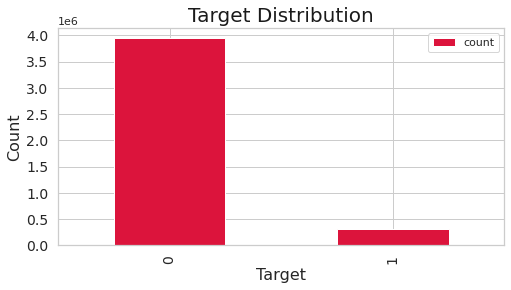

In [52]:
target = df.groupBy('target').count().toPandas()
target_df = pd.DataFrame(target)
target.set_index('count')
color = ['crimson']

target_plot = target_df.plot(figsize = (8, 4), kind='bar', x="target", y="count", color=color)
plt.xlabel("Target", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Target Distribution", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

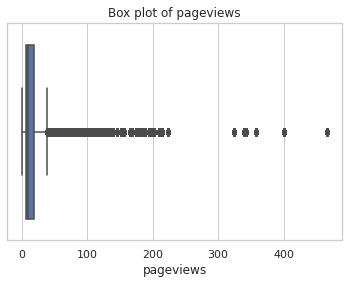

In [24]:
pageviews = df.select("pageviews").toPandas()

sns.set_theme(style="whitegrid")
sns.boxplot(x=pageviews["pageviews"])
plt.title("Box plot of pageviews")
plt.show()

In [53]:
# Transaform String Type Columns to Index and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

vector_indexer = StringIndexer(inputCols=["browser", "action_type", "v2ProductCategory"], outputCols=["browser_index", "action_type_index", "v2ProductCategory_index"], handleInvalid="keep").fit(df)
df_new = vector_indexer.transform(df)
vector_encoder = OneHotEncoder(inputCols=["browser_index", "action_type_index", "v2ProductCategory_index"], outputCols=["browser_vec","action_type_vec", "v2ProductCategory_vec"]).fit(df_new)
df_vectors = vector_encoder.transform(df_new)

In [61]:
# Transform dataframe input features,

assembler = (VectorAssembler(inputCols=[
                                        "browser_index", "sessionsPerDay",
                                        "pageviews","hits","timeOnSite", 
                                        "productClicks",
                                        "productListPosition",
                                         "sessionQualityDim",
                                        "action_type_index", 
                                        "v2ProductCategory_index", "target"],
                             outputCol="features"))

data = assembler.transform(df_vectors)

data.select("features").show(3)

+--------------------+
|            features|
+--------------------+
|(11,[1,2,3,4,6,9]...|
|[1.0,1.0,12.0,18....|
|(11,[1,2,3,4,6,9]...|
+--------------------+
only showing top 3 rows



In [62]:
# Perform Correlation of inputs and output fields

from pyspark.ml.stat import Correlation

pearson_corr = Correlation.corr(data, "features").head()
print("Pearson correlation matrix \n", str(pearson_corr[0]))

21/11/26 15:56:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/11/26 15:56:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Pearson correlation matrix 
 DenseMatrix([[ 1.        , -0.00249282, -0.09918392, -0.09584649, -0.07873579,
              -0.01356495,  0.02166195, -0.05181728, -0.02997168, -0.07829976,
              -0.07524568],
             [-0.00249282,  1.        ,  0.16352792,  0.15900805,  0.11543967,
               0.03239421, -0.02379862,  0.04993829,  0.10241909, -0.01919002,
               0.06294421],
             [-0.09918392,  0.16352792,  1.        ,  0.98234208,  0.69352694,
               0.05274281, -0.05657075,  0.18786216,  0.1384442 ,  0.13252296,
               0.36657578],
             [-0.09584649,  0.15900805,  0.98234208,  1.        ,  0.67296823,
               0.06701661, -0.06001939,  0.19553114,  0.15286953,  0.12783095,
               0.35031695],
             [-0.07873579,  0.11543967,  0.69352694,  0.67296823,  1.        ,
               0.03078293, -0.03380304,  0.17135067,  0.0949153 ,  0.08166165,
               0.26747503],
             [-0.01356495,  0.03239421,  

In [63]:
pearson_array = pearson_corr[0].toArray()

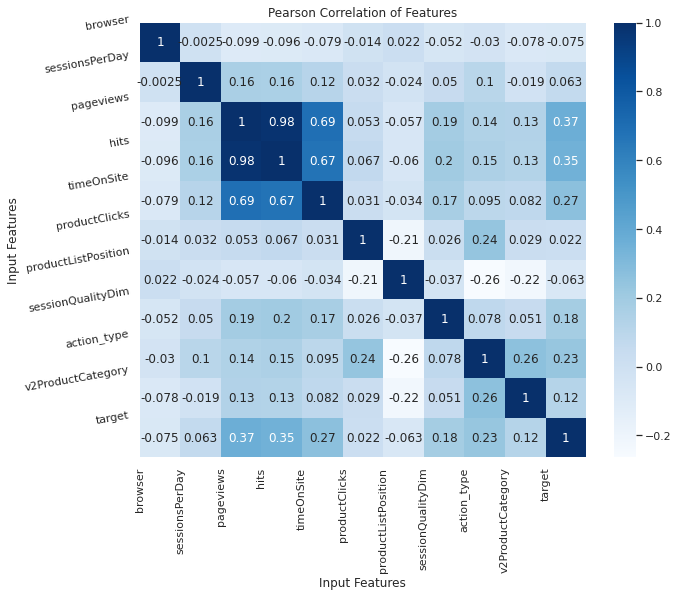

In [64]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
sns.heatmap(pearson_array, annot=True, cmap="Blues", ax=ax)

classes = [ "browser", "sessionsPerDay",
            "pageviews","hits","timeOnSite", 
            "productClicks",
            "productListPosition",
             "sessionQualityDim",
            "action_type", 
            "v2ProductCategory", "target"]

tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes, rotation=10)
plt.xlabel('Input Features')
plt.ylabel('Input Features') 
plt.title('Pearson Correlation of Features')
plt.show()

In [65]:
# Handle Imbalance using weight, calculate ratio of each class

y_collect = df_new.select("target").groupBy("target").count().collect()
unique_y = [x["target"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
class_weights

{0: 0.538670394344991, 1: 6.964893990210446}

In [76]:
# Use weights to handle imbalance
from itertools import chain

map_expr = fn.create_map([fn.lit(x) for x in chain(*class_weights.items())])

df_new = df_vectors.withColumn('weights', map_expr.getItem(fn.col('target')))

In [77]:
# Since pageviews, hits and timeOnsite are highly correlated and also correlated to target, use PCA
# to handle this

assembler = VectorAssembler(inputCols=["browser_vec", "sessionsPerDay",
                                        "pageviews","hits","timeOnSite", 
                                        "productClicks",
                                        "productListPosition",
                                         "sessionQualityDim",
                                        "action_type_vec", 
                                        "v2ProductCategory_vec", "target"
                                        ], outputCol="assemble_features")

output = assembler.transform(df_new)

output.select("assemble_features", "target").show(3)

+--------------------+------+
|   assemble_features|target|
+--------------------+------+
|(119,[0,33,34,35,...|     0|
|(119,[1,33,34,35,...|     0|
|(119,[0,33,34,35,...|     0|
+--------------------+------+
only showing top 3 rows



In [78]:
# Apply Normalisation before splitting
from pyspark.ml.feature import RobustScaler


scaler = RobustScaler(inputCol="assemble_features", outputCol="features",
                        withScaling=True, withCentering=False,
                        lower=0.25, upper=0.75)

scaler_model = scaler.fit(output)

df_scaled = scaler_model.transform(output)
df_scaled.limit(2).toPandas()

,sessionsPerDay,pageviews,hits,timeOnSite,sessionQualityDim,action_type,browser,productListPosition,productClicks,v2ProductCategory,target,browser_index,action_type_index,v2ProductCategory_index,browser_vec,action_type_vec,v2ProductCategory_vec,weights,assemble_features,features
0,1,7,8,1356,0,0,Chrome,7,0,Home/Apparel/Men's/Men's-T-Shirts/,0,0.0,0.0,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.53867,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,12,18,391,0,0,Safari,10,0,Home/Bags/,0,1.0,0.0,4.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.53867,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [79]:
features_label = df_scaled.withColumn("label", col("target"))

# Model Training and Validation

In [80]:
# Randomly split normalized data into train and test

df_model = features_label.select(["features", "label", "weights"])

train, test = df_model.randomSplit([0.7, 0.3], 56)
print('Test split:', test.count())
print('Train split:', train.count())

Test split: 1274588


Train split: 2974262


In [81]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def model_evaluation(results, metric, evaluator):
    
    predict_label = results.select("prediction", "label")

    
    print(metric + ": " + str(evaluator.evaluate(predict_label)))
    
    return evaluator.evaluate(predict_label)

In [82]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [83]:
RF = RandomForestClassifier(maxDepth=10, weightCol="weights")
RFModel = RF.fit(train)

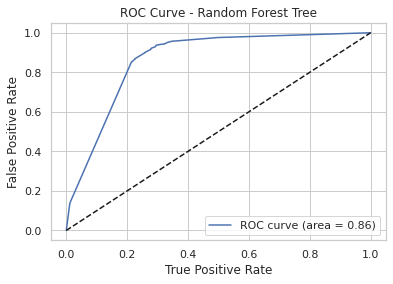

In [84]:
RF_summary = RFModel.summary

RF_result = RFModel.transform(test)



ROC = RF_summary.roc.toPandas()
label = 'ROC curve (area = %.2f)'% RF_summary.areaUnderROC
plt.plot(ROC['FPR'],ROC['TPR'], label=label)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Tree')
plt.legend(loc="lower right")
plt.show()

In [85]:
auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(RF_result, "areaUnderROC",  auc_eval)
model_evaluation(RF_result, "accuracy",  accuracy_eval)
model_evaluation(RF_result, "f1",  f1_eval)
model_evaluation(RF_result, "Precision",  precision_eval)
model_evaluation(RF_result, "Recall",  recall_eval)

areaUnderROC: 0.8216888063296757


accuracy: 0.7354321553317621


f1: 0.798967159315507


Precision: 0.9917461646232639


Recall: 0.7209741848124676


0.7209741848124676

In [87]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [88]:
LR = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, weightCol="weights")

LR_model = LR.fit(train)

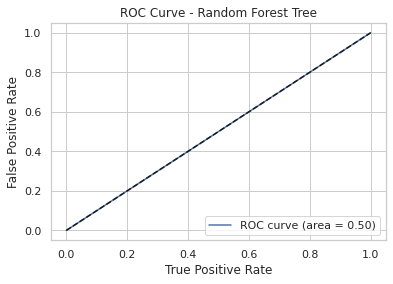

In [90]:
# Test the model
LR_summary = LR_model.summary

LR_result = LR_model.transform(test)



ROC = LR_summary.roc.toPandas()
label = 'ROC curve (area = %.2f)'% LR_summary.areaUnderROC
plt.plot(ROC['FPR'],ROC['TPR'], label=label)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Tree')
plt.legend(loc="lower right")
plt.show()

In [91]:
auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(LR_result, "areaUnderROC",  auc_eval)
model_evaluation(LR_result, "accuracy",  accuracy_eval)
model_evaluation(LR_result, "f1",  f1_eval)
model_evaluation(LR_result, "Precision",  precision_eval)
model_evaluation(LR_result, "Recall",  recall_eval)

areaUnderROC: 0.5


accuracy: 0.07177691928685975


f1: 0.009613803114439849


Precision: 0.0


Recall: 0.0


0.0